### Imports

In [13]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from PIL import Image
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
import numpy as np
import torch
from torch import nn
from tqdm import tqdm as progressbar
from skimage.feature import (
    local_binary_pattern as lbp,
    hog
)
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_tensor
import cv2 as cv
from sklearn import metrics

In [2]:
# img = Image.open("../datasets/UCMerced_LandUse/Images/airplane/airplane00.tif") 
# img = ToTensor()(img)

# # Step 1: Initialize model with the best available weights
# weights = ResNet50_Weights.DEFAULT
# model = resnet50(weights=weights)
# model.eval()

# # Step 2: Initialize the inference transforms
# preprocess = weights.transforms()

# # Step 3: Apply inference preprocessing transforms
# batch = preprocess(img).unsqueeze(0)

# # Step 4: Use the model and print the predicted category
# prediction = model(batch).squeeze(0).softmax(0)
# class_id = prediction.argmax().item()
# score = prediction[class_id].item()
# category_name = weights.meta["categories"][class_id]
# print(f"{category_name}: {100 * score:.1f}%")

warplane: 48.2%


/Users/rchristopher/mambaforge/envs/ms_research/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [2]:
total_dataset = datasets.ImageFolder('Images/', transform=None)
# total_dataset = datasets.ImageFolder('../datasets/UCMerced_LandUse/Images/', transform=None)
train_size = int(0.8 * len(total_dataset))
test_size = len(total_dataset) - train_size

train_dataset, test_dataset = random_split(total_dataset, [train_size, test_size])

# train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=16)
# test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=16)

# use list comprehension to convert every train image to np.ndarray
train_images = [np.asarray(img) for img, _ in train_dataset]
# iterate through the dataset again to get the labels  as a single array
train_labels = [label for _, label in train_dataset]

# repeat this same process for the test dataset
test_images = [np.asarray(img) for img, _ in test_dataset]
test_labels = [label for _, label in test_dataset]

Number of Train Images: 1680
Number of Test Images: 420


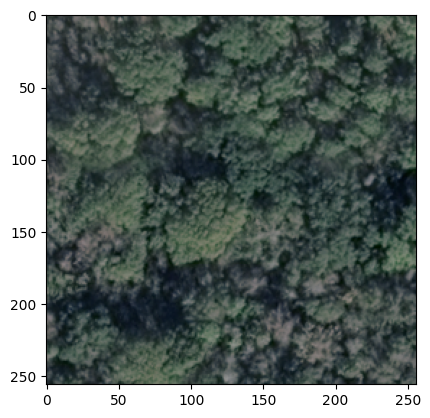

In [3]:
plt.imshow(train_images[0])
print(f'Number of Train Images: {len(train_images)}')
print(f'Number of Test Images: {len(test_images)}')


In [4]:
from torchvision.transforms.functional import normalize

def preprocess(image):
    # 28x28 is too small for VGG, the min size is 32x32
    image = cv.resize(image, (256, 256))
    # image = cv.cvtColor(image, cv.COLOR)
    # use torchvision.transforms.functional.to_tensor to convert it 
    tensor = to_tensor(image).unsqueeze(0)
    
    return tensor

In [5]:
train_tensors = []
for img in progressbar(train_images):
    train_tensors.append(preprocess(img))
train_tensors = torch.cat(train_tensors, dim=0)

test_tensors = []
for img in progressbar(test_images):
    test_tensors.append(preprocess(img))
test_tensors = torch.cat(test_tensors, dim=0)

train_labels_tensor = torch.Tensor(train_labels).long()
train_labels_tensor_1hot = torch.nn.functional.one_hot(train_labels_tensor, num_classes=21)

test_labels_tensor = torch.Tensor(test_labels).long()
test_labels_tensor_1hot = torch.nn.functional.one_hot(test_labels_tensor, num_classes=21)

100%|██████████| 420/420 [00:00<00:00, 4134.23it/s]


### Declare Resnet 50 Model

In [7]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

In [8]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)

In [9]:
from tqdm import trange # progress bar based range function

def train(model, train_data, train_labels, loss_function, optimizer, normalize=True, batch_size=16):
    
    model.train()
    
    # we'll keep track of the loss 
    # and acc of our model
    epoch_loss = 0
    epoch_correct = 0
    
    # the number of batches that we will need for an epoch 
    # of training
    n_batches = len(train_data) // batch_size
    
    # should we normalize our data
    if normalize:
        # subtract mean and divide by std
        train_data = (train_data - train_data.mean()) / train_data.std()
    
    # for each batch (with progress bar)
    for batch_idx in trange(n_batches):
        # get the start and end idx for the batch
        batch_start = batch_size * batch_idx
        batch_end = batch_start + batch_size
        
        # get the data and labels for this batch
        train_batch = train_data[batch_start:batch_end]
        labels = train_labels[batch_start:batch_end]
        
        optimizer.zero_grad()
        
        model_outputs = model(train_batch)
        
        # calculate the loss
        # using the model outputs
        # and the desired labels
        _, labels_c = torch.max(labels, 1)
        
        # NLL and CrossEntropy need labels as [0, 4, 6, etc]
        if isinstance(loss_function, (torch.nn.NLLLoss, torch.nn.CrossEntropyLoss)): 
            loss = loss_function(model_outputs.float(), labels_c.long())
        # the others need 1 hot encoding
        else:
            loss = loss_function(model_outputs.float(), labels.float())
        
        # check that the loss is still real values
        if torch.isnan(loss):
            raise RuntimeError("Loss reached NaN!")
        
        loss.backward()
        optimizer.step()
        
        
        _, predictions = torch.max(model_outputs, 1)
        epoch_correct += torch.sum(predictions == labels_c)        
        
        # add this batch's loss to the total loss
        epoch_loss += loss.item()

    # print the avg loss and acc of all the batches
    # for this epoch
    print(f"Loss = {epoch_loss / n_batches:.4f}")
    print(f"Train Acc = {epoch_correct / len(train_labels) * 100:.2f}%") 
    
    # return the model
    return model

In [10]:
n_epochs = 10
for i in range(n_epochs):
    print("---" * 20 + f"\nEpoch {i+1} / {n_epochs}")
    model = train(model, train_tensors, train_labels_tensor_1hot, loss, opt, batch_size=15, normalize=True)

------------------------------------------------------------
Epoch 1 / 10


100%|██████████| 112/112 [03:00<00:00,  1.61s/it]


Loss = 3.1287
Train Acc = 42.38%
------------------------------------------------------------
Epoch 2 / 10


100%|██████████| 112/112 [02:48<00:00,  1.50s/it]


Loss = 0.2699
Train Acc = 93.57%
------------------------------------------------------------
Epoch 3 / 10


100%|██████████| 112/112 [02:58<00:00,  1.59s/it]


Loss = 0.0286
Train Acc = 99.82%
------------------------------------------------------------
Epoch 4 / 10


100%|██████████| 112/112 [02:36<00:00,  1.40s/it]


Loss = 0.0066
Train Acc = 100.00%
------------------------------------------------------------
Epoch 5 / 10


  3%|▎         | 3/112 [00:05<03:27,  1.90s/it]


KeyboardInterrupt: 

In [11]:
model.eval()
# an empty tensor to hold predicted classes
y_pred = np.empty(len(test_tensors))

# this tells torch that we are only
# going to perform forward passes
with torch.no_grad():
    # for each feature
    for i, image in enumerate(progressbar(test_tensors)):
        # forward pass - length of 10
        raw_prediction = model(image.unsqueeze(0))
        # get the argmax -- i.e., the cpredicted class
        _, predicted_class = torch.max(raw_prediction, 1)
        # save it to our list
        y_pred[i] = predicted_class.item()

100%|██████████| 420/420 [00:17<00:00, 24.56it/s]


In [16]:
print(f'Accuracy: {metrics.accuracy_score(test_labels, y_pred)*100:.2f}%')

Accuracy: 81.90%
